# Project

The aim of this project is to extract and recognize handwriting. It's divided in 3 part:
1. Paragraph segmentation
2. Line segmentation
3. Handwriting recognition



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = "/content/data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Library and Data

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Import matplotlib for visualization
import matplotlib.pyplot as plt

import numpy as np

import os
import zipfile

# Check versions
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

The forms dataset come from kaggle:
https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset

In [ ]:
zip_file_name = 'drive/MyDrive/colab/archive.zip'
base_path = "extracted_files/data/"
forms_list = []

In [ ]:
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_files/')

In [ ]:
folder_path = base_path

# Check if the folder exists
if os.path.exists(folder_path):
    for root, directories, files in os.walk(folder_path):
        for file in files:
            forms_list.append(os.path.join(root, file))
else:
    print(f"The folder '{folder_path}' does not exist.")

In [ ]:
len(forms_list)

1539

In [ ]:
print(forms_list[0])

extracted_files/data/292/f07-084a.png


In [ ]:
from PIL import Image
from IPython.display import display

image = Image.open(forms_list[0])
display(image)
image.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
image.size

(2479, 3542)

## Binary segmentation

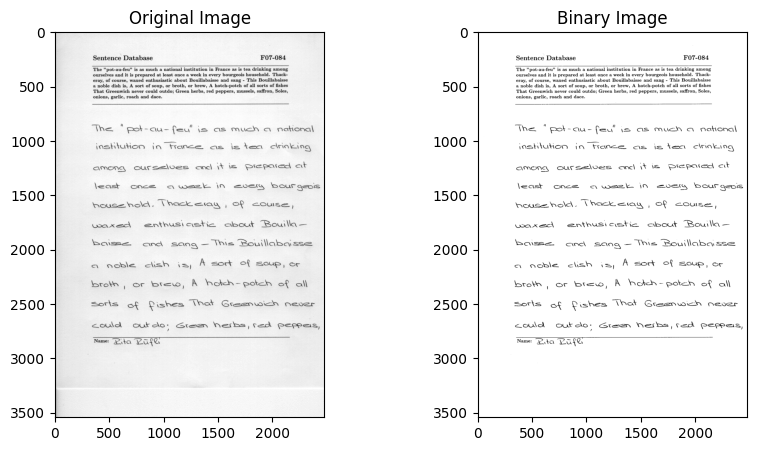

In [ ]:
import cv2

# Load the grayscale image
image = cv2.imread(forms_list[0], cv2.IMREAD_GRAYSCALE)

# Apply a threshold
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

# Display the original and binary images using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')

plt.show()

In [ ]:
# Initialize an empty list to store binary images
binary_images = []

# Process each image
for image_path in forms_list[:100]:
    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply a threshold
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

    # Append the binary image to the list
    binary_images.append(binary_image)

# Convert the list of binary images to a NumPy array
binary_images_array = np.array(binary_images)

In [ ]:
len(binary_images_array)

100

In [ ]:
binary_images_array[0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

##  MSER (Maximally Stable Extremal Regions)

In [ ]:
# Load the grayscale image
image = cv2.imread(forms_list[0], cv2.IMREAD_GRAYSCALE)

# Apply a threshold
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

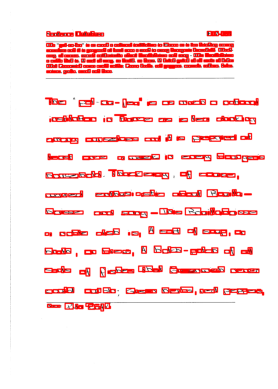

In [ ]:
# Initialize the MSER detector with modified parameters
mser = cv2.MSER_create(delta=5, min_area=100, max_area=5000, max_variation=0.2, min_diversity=0.7)

# Detect MSER regions
regions, _ = mser.detectRegions(binary_image)

# Draw bounding boxes around the MSER regions
image_rgb = cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB)
img_with_boxes = image_rgb.copy()
for region in regions:
    min_x, min_y = region.min(axis=0)
    max_x, max_y = region.max(axis=0)
    cv2.rectangle(img_with_boxes, (min_x, min_y), (max_x, max_y), (0, 0, 255), 10)

# Display the result using matplotlib without color space conversion
plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

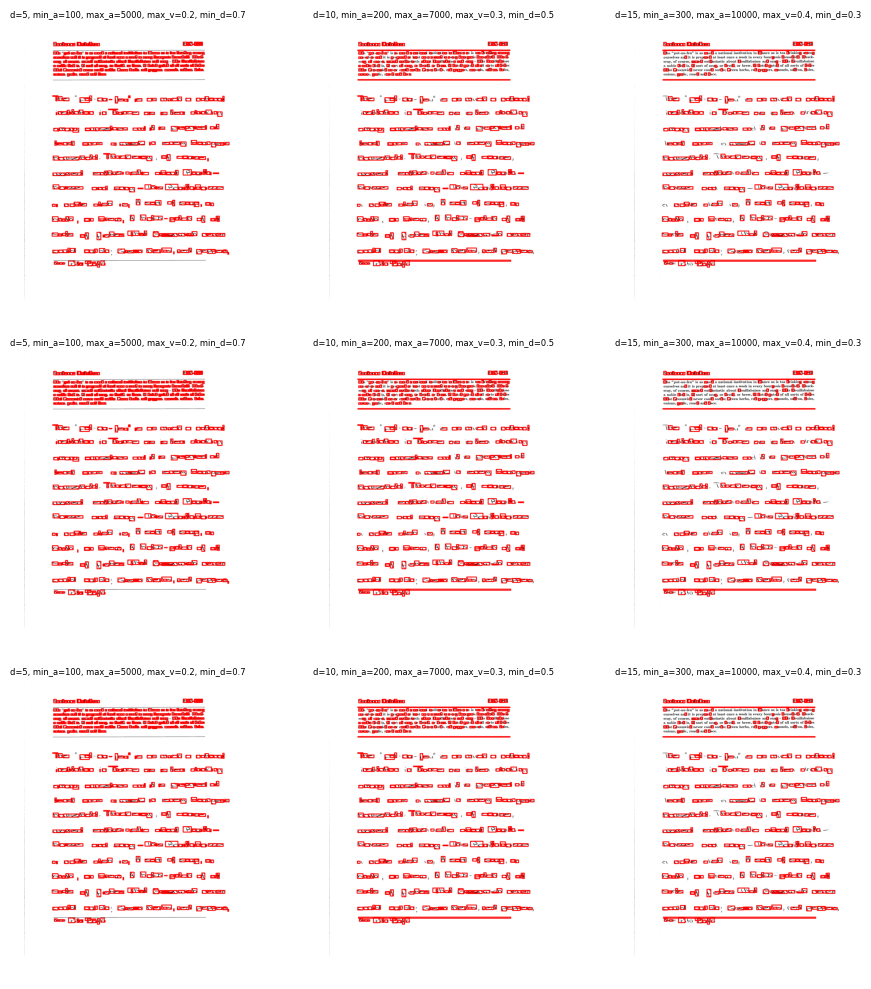

In [ ]:
def display_mser_result(ax, delta, min_area, max_area, max_variation, min_diversity):
    # Initialize the MSER detector with modified parameters
    mser = cv2.MSER_create(delta=delta, min_area=min_area, max_area=max_area, max_variation=max_variation, min_diversity=min_diversity)

    # Detect MSER regions
    regions, _ = mser.detectRegions(binary_image)

    # Draw bounding boxes around the MSER regions
    image_rgb = cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB)
    img_with_boxes = image_rgb.copy()
    for region in regions:
        min_x, min_y = region.min(axis=0)
        max_x, max_y = region.max(axis=0)
        cv2.rectangle(img_with_boxes, (min_x, min_y), (max_x, max_y), (0, 0, 255), 10)

    # Display the result using matplotlib without color space conversion
    ax.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(f"d={delta}, min_a={min_area}, max_a={max_area}, max_v={max_variation}, min_d={min_diversity}", fontsize=6)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

# Example usage with different values
delta_values = [5, 10, 15, 5, 10, 15, 5, 10, 15]
min_area_values = [100, 200, 300, 100, 200, 300, 100, 200, 300]
max_area_values = [5000, 7000, 10000, 5000, 7000, 10000, 5000, 7000, 10000]
max_variation_values = [0.2, 0.3, 0.4, 0.2, 0.3, 0.4, 0.2, 0.3, 0.4]
min_diversity_values = [0.7, 0.5, 0.3, 0.7, 0.5, 0.3, 0.7, 0.5, 0.3]

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        index = i * 3 + j
        if index < len(delta_values):  # Ensure not to go beyond the list length
            display_mser_result(ax, delta=delta_values[index], min_area=min_area_values[index],
                                 max_area=max_area_values[index], max_variation=max_variation_values[index],
                                 min_diversity=min_diversity_values[index])

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()

## Implémentation

In [ ]:
def dilate_bbs(bbs, dilation_d, dilation_max):
    bbs_l = []
    for bb in bbs:
        (x, y, w, h) = bb
        (centre_x, centre_y) = (x + w/2, y + h/2)
        (x1, y1, x2, y2) = (x, y, x + w, y + h)

        dx = (centre_x - x1) * dilation_d
        dy = (centre_y - y1) * dilation_d

        if dilation_max:
            if dx > dilation_max[0]:
                dx = dilation_max[0]
            if dy > dilation_max[1]:
                dy = dilation_max[1]

        x1_l = centre_x - dx
        y1_l = centre_y - dy
        x2_l = centre_x + dx
        y2_l = centre_y + dy

        bb_l = (int(x1_l), int(y1_l), int(x2_l - x1_l), int(y2_l - y1_l))
        bbs_l.append(bb_l)
    return bbs_l

def does_rect_overlap(bb1, bb2):
    (x1_1, y1_1, w_1, h_1) = bb1
    (x1_1, y1_1, x2_1, y2_1) = (x1_1, y1_1, x1_1 + w_1, y1_1 + h_1)

    (x1_2, y1_2, w_2, h_2) = bb2
    (x1_2, y1_2, x2_2, y2_2) = (x1_2, y1_2, x1_2 + w_2, y1_2 + h_2)

    h_overlaps = True
    v_overlaps = True
    if (x1_1 > x2_2) or (x2_1 < x1_2):
        h_overlaps = False
    if (y1_1 > y2_2) or (y2_1 < y1_2):
        v_overlaps = False
    return h_overlaps and v_overlaps

def get_intersection_percentage(bb1, bb2):
    if not does_rect_overlap(bb1, bb2):
        return 0
    (x1_1, y1_1, w_1, h_1) = bb1
    (x1_1, y1_1, x2_1, y2_1) = (x1_1, y1_1, x1_1 + w_1, y1_1 + h_1)

    (x1_2, y1_2, w_2, h_2) = bb2
    (x1_2, y1_2, x2_2, y2_2) = (x1_2, y1_2, x1_2 + w_2, y1_2 + h_2)

    x_a = max(x1_1, x1_2)
    y_a = max(y1_1, y1_2)
    x_b = min(x2_1, x2_2)
    y_b = min(y2_1, y2_2)

    inter_area = (x_b - x_a + 1) * (y_b - y_a + 1)

    bb1_area = (w_1 + 1) * (h_1 + 1)
    bb2_area = (w_2 + 1) * (h_2 + 1)

    intersection_percentage = inter_area / float(bb1_area)
    return intersection_percentage

def get_intersection_percentage_matrix(bbs):
    n = len(bbs)
    ip = np.zeros(shape=(n, n))
    for i in range(n):
        for j in range(n):
            ip[i, j] = get_intersection_percentage(bbs[i], bbs[j])
    return ip

def make_new_bb_from_intersect_bbs(bbs):
    max_x = np.max([bb[0] + bb[2] for bb in bbs])
    min_x = np.min([bb[0] for bb in bbs])
    max_y = np.max([bb[1] + bb[3] for bb in bbs])
    min_y = np.min([bb[1] for bb in bbs])
    return (min_x, min_y, max_x - min_x, max_y - min_y)

def reduce_bbs_by_inetersection_percentage(bbs, in_matrix_thresholded):
    new_bbs = []
    for i in range(in_matrix_thresholded.shape[0]):
        in_i = in_matrix_thresholded[i, :]
        intersections_indexes = np.where(in_i)[0]
        if len(intersections_indexes) == 0:
            new_bbs.append(bbs[i])
        else:
            intersection_bbs = [bbs[i]]
            for intersections_index in intersections_indexes:
                intersection_bbs.append(bbs[intersections_index])
            new_bb = make_new_bb_from_intersect_bbs(intersection_bbs)
            if new_bb not in new_bbs:
                new_bbs.append(new_bb)
    return new_bbs

def reduce_intersecting_bbs(bbs, intersection_threshold):
    new_bbs = bbs
    while True:
        old_bbs_no = len(bbs)
        in_matrix = get_intersection_percentage_matrix(bbs)
        in_matrix_thresholded = in_matrix > intersection_threshold
        bbs = reduce_bbs_by_inetersection_percentage(bbs, in_matrix_thresholded)
        if old_bbs_no == len(bbs):
            break

    return bbs

def get_bounding_boxs_of_passages(bbs, iterations, ip_threshold, dilation_d, dilation_max=None, intermetiate_bbs=None):
    max_bbs = 150
    for i in range(iterations):
        bbs = dilate_bbs(bbs, dilation_d, dilation_max)
        bbs = reduce_intersecting_bbs(bbs, ip_threshold)
        if intermetiate_bbs is not None:
            intermetiate_bbs.append(bbs)

        if len(bbs) > max_bbs:
            extra_iterations = len(bbs) // max_bbs
            iterations += extra_iterations

    return bbs

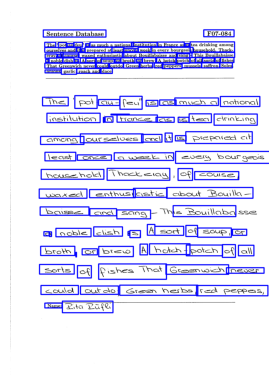

In [ ]:
# Initialize the MSER detector with modified parameters
mser = cv2.MSER_create(delta=5, min_area=100, max_area=5000, max_variation=0.2, min_diversity=0.7)

# Detect MSER regions
regions, _ = mser.detectRegions(binary_image)

# Convert regions to bounding boxes
bbs = [cv2.boundingRect(region) for region in regions]

# Parameters for dilation and reduction
dilation_d = 1.1  # Adjust the dilation factor as needed
iterations = 5  # Adjust the number of iterations as needed
ip_threshold = 0.1  # Adjust the intersection percentage threshold as needed
dilation_max = (300, 300)  # Adjust the maximum dilation values as needed


# Apply dilation and reduction to MSER bounding boxes
final_bbs = get_bounding_boxs_of_passages(bbs, iterations, ip_threshold, dilation_d, dilation_max)

# Draw final bounding boxes on the image
image_rgb = cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB)
img_with_final_boxes = image_rgb.copy()

for bb in final_bbs:
    min_x, min_y, w, h = bb
    max_x, max_y = min_x + w, min_y + h
    cv2.rectangle(img_with_final_boxes, (int(min_x), int(min_y)), (int(max_x), int(max_y)), (0, 0, 255), 10)

# Display the result using matplotlib
plt.imshow(img_with_final_boxes)
plt.axis('off')
plt.show()

In [ ]:
def merge_horizontal_bbs(bbs, merge_threshold):
    merged_bbs = []

    for bb in bbs:
        x, y, w, h = bb
        merged = False

        for i, merged_bb in enumerate(merged_bbs):
            x_m, y_m, w_m, h_m = merged_bb
            if y - merge_threshold <= y_m <= y + merge_threshold:
                # Merge horizontally aligned bounding boxes
                merged_bb = (min(x, x_m), min(y, y_m), max(x + w, x_m + w_m) - min(x, x_m), max(y + h, y_m + h_m) - min(y, y_m))
                merged_bbs[i] = merged_bb
                merged = True
                break

        if not merged:
            merged_bbs.append(bb)

    return merged_bbs

def merge_inside_bbs(bbs):
    merged_bbs = []

    for i, bb1 in enumerate(bbs):
        x1, y1, w1, h1 = bb1
        merged = False

        for j, bb2 in enumerate(merged_bbs):
            x2, y2, w2, h2 = bb2

            if (
                x2 <= x1 <= x2 + w2 or  # bb1 is fully or partially inside bb2 horizontally
                x1 <= x2 <= x1 + w1    # bb2 is fully or partially inside bb1 horizontally
            ) and (
                y2 <= y1 <= y2 + h2 or  # bb1 is fully or partially inside bb2 vertically
                y1 <= y2 <= y1 + h1    # bb2 is fully or partially inside bb1 vertically
            ):
                # Merge bounding boxes that are inside each other
                merged_bb = (
                    min(x1, x2),
                    min(y1, y2),
                    max(x1 + w1, x2 + w2) - min(x1, x2),
                    max(y1 + h1, y2 + h2) - min(y1, y2)
                )
                merged_bbs[j] = merged_bb
                merged = True
                break

        if not merged:
            merged_bbs.append(bb1)

    return merged_bbs

def calculate_iou(bb1, bb2):
    x1, y1, w1, h1 = bb1
    x2, y2, w2, h2 = bb2

    intersection_x1 = max(x1, x2)
    intersection_y1 = max(y1, y2)
    intersection_x2 = min(x1 + w1, x2 + w2)
    intersection_y2 = min(y1 + h1, y2 + h2)

    intersection_area = max(0, intersection_x2 - intersection_x1) * max(0, intersection_y2 - intersection_y1)

    area_bb1 = w1 * h1
    area_bb2 = w2 * h2

    iou = intersection_area / float(area_bb1 + area_bb2 - intersection_area)
    return iou

def merge_overlapping_bbs(bbs, merge_threshold):

    merged_bbs = []

    for i, bb1 in enumerate(bbs):
        x1, y1, w1, h1 = bb1
        merged = False

        for j, bb2 in enumerate(merged_bbs):
            x2, y2, w2, h2 = bb2

            if calculate_iou(bb1, bb2) > merge_threshold:
                # Merge overlapping bounding boxes
                merged_bb = (
                    min(x1, x2),
                    min(y1, y2),
                    max(x1 + w1, x2 + w2) - min(x1, x2),
                    max(y1 + h1, y2 + h2) - min(y1, y2)
                )
                merged_bbs[j] = merged_bb
                merged = True
                break

        if not merged:
            merged_bbs.append(bb1)

    return merged_bbs


def filter_small_bbs(bbs, min_size=10):
    filtered_bbs = []

    for bb in bbs:
        x, y, w, h = bb
        if w >= min_size and h >= min_size:
            filtered_bbs.append(bb)

    return filtered_bbs

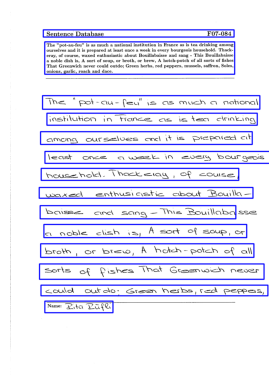

In [ ]:
    # Merge horizontally aligned bounding boxes
    merge_threshold = 50  # Adjust as needed
    merged_bbs = merge_horizontal_bbs(final_bbs, merge_threshold)

    # Merge overlapping and inside bounding boxes
    merge_threshold_overlapping = 0.1  # Adjust as needed

    merged_bbs_overlapping = merge_overlapping_bbs(merged_bbs, merge_threshold_overlapping)
    merged_bbs_inside = merge_inside_bbs(merged_bbs_overlapping)
    merged_bbs = merged_bbs_inside

    # Filter out small bounding boxes
    merged_bbs_inside = filter_small_bbs(merged_bbs_inside, min_size=10)


    # Draw final merged bounding boxes on the image
    img_with_final_merged_boxes = cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB)
    for bb in merged_bbs_inside:
        min_x, min_y, w, h = bb
        max_x, max_y = min_x + w, min_y + h
        cv2.rectangle(img_with_final_merged_boxes, (int(min_x), int(min_y)), (int(max_x), int(max_y)), (0, 0, 255), 10)

    # Display the result using matplotlib without color space conversion
    plt.imshow(img_with_final_merged_boxes)
    plt.axis('off')
    plt.show()

In [ ]:
def merge_between_indices(bbs, start_index, end_index):
    if end_index >= len(bbs) or start_index >= end_index or start_index < 0:
        return bbs

    merged_bbs = bbs[:start_index]  # Keep the bounding boxes before the start_index

    # Merge bounding boxes between start_index and end_index
    merged_bb = bbs[start_index]
    for i in range(start_index + 1, end_index):
        x, y, w, h = bbs[i]
        min_x = min(merged_bb[0], x)
        min_y = min(merged_bb[1], y)
        max_x = max(merged_bb[0] + merged_bb[2], x + w)
        max_y = max(merged_bb[1] + merged_bb[3], y + h)
        merged_bb = (min_x, min_y, max_x - min_x, max_y - min_y)

    merged_bbs.append(merged_bb)  # Add the merged bounding box

    merged_bbs.extend(bbs[end_index:])  # Add the bounding boxes after the end_index

    return merged_bbs

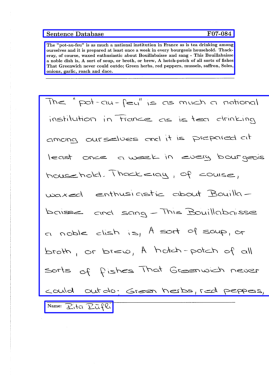

In [ ]:
# Find the indices of bounding boxes 3 and (n - 1) and merge the bounding boxes in between
bb3_index = 2  # Index of bounding box 3
last_index = len(merged_bbs_inside) - 1  # Index of the last bounding box

sorted_bbs = sorted(merged_bbs_inside, key=lambda bb: bb[1])  # Sorting by the y-coordinate (index 1)

# Merge bounding boxes between indices 3 and (n - 1)
merged_bbs_inside = merge_between_indices(sorted_bbs, bb3_index, last_index)

# Draw final merged bounding boxes on the image
img_with_merged_between_boxes = cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB)

for bb in merged_bbs_inside:
    min_x, min_y, w, h = bb
    max_x, max_y = min_x + w, min_y + h
    cv2.rectangle(img_with_merged_between_boxes, (int(min_x), int(min_y)), (int(max_x), int(max_y)), (0, 0, 255), 10)

# Display the result using matplotlib without color space conversion
plt.imshow(img_with_merged_between_boxes)
plt.axis('off')
plt.show()

## Généralisation

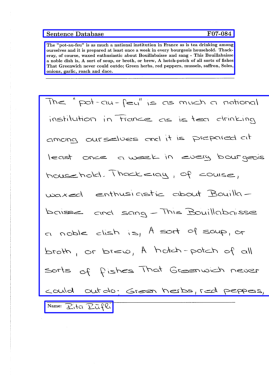

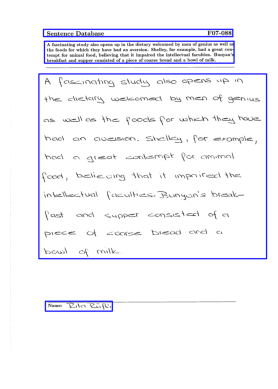

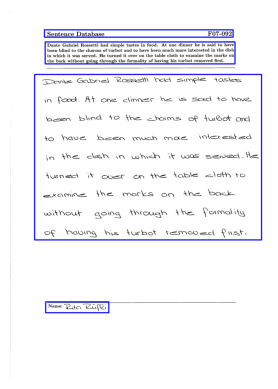

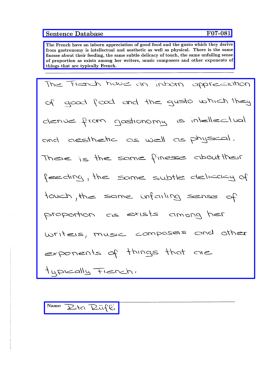

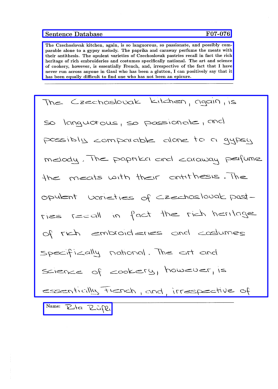

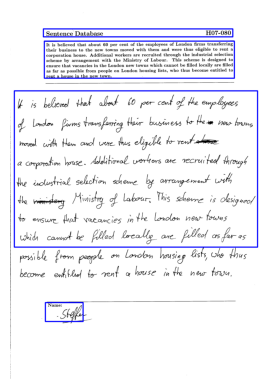

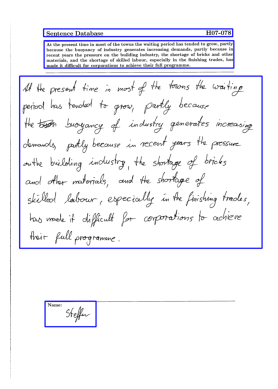

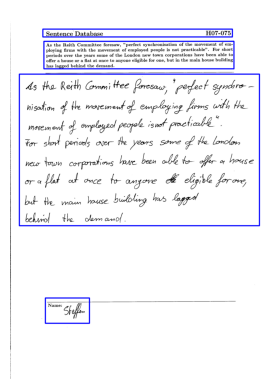

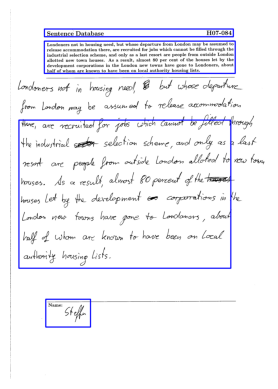

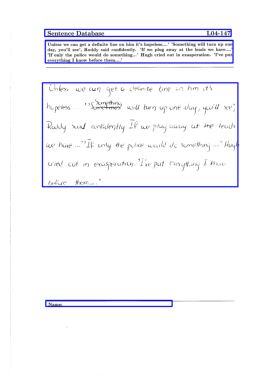

In [ ]:
# Assuming binary_images_array is a list or array of binary images
for binary_image in binary_images_array[:10]:
    # Initialize the MSER detector with modified parameters
    mser = cv2.MSER_create(delta=5, min_area=100, max_area=5000, max_variation=0.2, min_diversity=0.7)

    # Detect MSER regions
    regions, _ = mser.detectRegions(binary_image)

    # Convert regions to bounding boxes
    bbs = [cv2.boundingRect(region) for region in regions]

    # Parameters for dilation and reduction
    dilation_d = 1.1  # Adjust the dilation factor as needed
    iterations = 5  # Adjust the number of iterations as needed
    ip_threshold = 0.1  # Adjust the intersection percentage threshold as needed
    dilation_max = (300, 300)  # Adjust the maximum dilation values as needed

    # Apply dilation and reduction to MSER bounding boxes
    final_bbs = get_bounding_boxs_of_passages(bbs, iterations, ip_threshold, dilation_d, dilation_max)

    # Merge horizontally aligned bounding boxes
    merge_threshold = 50  # Adjust as needed
    merged_bbs = merge_horizontal_bbs(final_bbs, merge_threshold)

    # Merge overlapping and inside bounding boxes
    merge_threshold_overlapping = 0.1  # Adjust as needed

    merged_bbs_overlapping = merge_overlapping_bbs(merged_bbs, merge_threshold_overlapping)
    merged_bbs_inside = merge_inside_bbs(merged_bbs_overlapping)
    merged_bbs = merged_bbs_inside

    # Filter out small bounding boxes
    merged_bbs_inside = filter_small_bbs(merged_bbs_inside, min_size=10)

    # Find the indices of bounding boxes 3 and (n - 1) and merge the bounding boxes in between
    bb3_index = 2  # Index of bounding box 3
    last_index = len(merged_bbs_inside) - 1  # Index of the last bounding box

    sorted_bbs = sorted(merged_bbs_inside, key=lambda bb: bb[1])  # Sorting by the y-coordinate (index 1)

    # Merge bounding boxes between indices 3 and (n - 1)
    merged_bbs_inside = merge_between_indices(sorted_bbs, bb3_index, last_index)

    # Draw final merged bounding boxes on the image
    img_with_merged_between_boxes = cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB)

    for bb in merged_bbs_inside:
      min_x, min_y, w, h = bb
      max_x, max_y = min_x + w, min_y + h
      cv2.rectangle(img_with_merged_between_boxes, (int(min_x), int(min_y)), (int(max_x), int(max_y)), (0, 0, 255), 10)

    # Display the result using matplotlib without color space conversion
    plt.imshow(img_with_merged_between_boxes)
    plt.axis('off')
    plt.show()

# Extraction

In [ ]:
# Define a function to save images based on bounding boxes
def save_images_with_bounding_boxes(bbs, image_array, index, save_path):
    os.makedirs(save_path, exist_ok=True)
    for i, bb in enumerate(bbs):
        x, y, w, h = bb
        # Check if it's bounding box 2 or 3
        if i == 1 or i == 2:
            image_name = f"image_{index}_bb_{i+1}.png"
            cropped_img = image_array[y:y+h, x:x+w]
            cv2.imwrite(os.path.join(save_path, image_name), cropped_img)

In [ ]:
save_path = "paragraph_images"

# Assuming binary_images_array is a list or array of binary images
for index, binary_image in enumerate(binary_images_array[:10]):
    # Initialize the MSER detector with modified parameters
    mser = cv2.MSER_create(delta=5, min_area=100, max_area=5000, max_variation=0.2, min_diversity=0.7)

    # Detect MSER regions
    regions, _ = mser.detectRegions(binary_image)

    # Convert regions to bounding boxes
    bbs = [cv2.boundingRect(region) for region in regions]

    # Parameters for dilation and reduction
    dilation_d = 1.1  # Adjust the dilation factor as needed
    iterations = 5  # Adjust the number of iterations as needed
    ip_threshold = 0.1  # Adjust the intersection percentage threshold as needed
    dilation_max = (300, 300)  # Adjust the maximum dilation values as needed

    # Apply dilation and reduction to MSER bounding boxes
    final_bbs = get_bounding_boxs_of_passages(bbs, iterations, ip_threshold, dilation_d, dilation_max)

    # Merge horizontally aligned bounding boxes
    merge_threshold = 50  # Adjust as needed
    merged_bbs = merge_horizontal_bbs(final_bbs, merge_threshold)

    # Merge overlapping and inside bounding boxes
    merge_threshold_overlapping = 0.1  # Adjust as needed

    merged_bbs_overlapping = merge_overlapping_bbs(merged_bbs, merge_threshold_overlapping)
    merged_bbs_inside = merge_inside_bbs(merged_bbs_overlapping)
    merged_bbs = merged_bbs_inside

    # Filter out small bounding boxes
    merged_bbs_inside = filter_small_bbs(merged_bbs_inside, min_size=10)

    # Find the indices of bounding boxes 3 and (n - 1) and merge the bounding boxes in between
    bb3_index = 2  # Index of bounding box 3
    last_index = len(merged_bbs_inside) - 1  # Index of the last bounding box

    sorted_bbs = sorted(merged_bbs_inside, key=lambda bb: bb[1])  # Sorting by the y-coordinate (index 1)

    # Merge bounding boxes between indices 3 and (n - 1)
    merged_bbs_inside = merge_between_indices(sorted_bbs, bb3_index, last_index)
    final_bbs = sorted(merged_bbs_inside, key=lambda bb: bb[1])  # Sorting by the y-coordinate (index 1)

    # Extract and save bounding boxes 2 and 3
    save_images_with_bounding_boxes(final_bbs, binary_image, index, save_path)
